In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import ipywidgets as widgets
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
from IPython.display import HTML
from base64 import b64encode
%matplotlib inline

In [2]:
!pip install opencv-python
!pip install torch imageio ipython
!pip install imageio-ffmpeg

In [3]:
import torch
import numpy as np
from IPython.display import Video, display
import cv2
import tempfile
import os

def display_tensor_as_video_opencv(tensor: torch.Tensor, fps: int = 30):
    """
    Display a PyTorch tensor as a video in a Jupyter notebook using OpenCV.

    Parameters:
    -----------
    tensor : torch.Tensor
        The tensor to display, with shape (C, T, H, W).
        - C: Number of channels (e.g., 3 for RGB).
        - T: Number of frames (time steps).
        - H: Height of each frame.
        - W: Width of each frame.
    fps : int, optional
        Frames per second for the video playback (default is 30).
    """
    # Validate tensor dimensions
    if tensor.ndim != 4:
        raise ValueError(f"Expected tensor with 4 dimensions (C, T, H, W), but got {tensor.ndim} dimensions.")
    
    C, T, H, W = tensor.shape
    if C not in [1, 3]:
        raise ValueError(f"Unsupported number of channels: {C}. Only 1 (grayscale) or 3 (RGB) are supported.")
    
    # Move tensor to CPU and convert to NumPy
    tensor = tensor.cpu().detach()
    np_tensor = tensor.numpy()

    # Rearrange dimensions to (T, H, W, C)
    np_tensor = np.transpose(np_tensor, (1, 2, 3, 0))  # (T, H, W, C)

    # Handle grayscale tensors by repeating the channel dimension
    if C == 1:
        np_tensor = np.repeat(np_tensor, 3, axis=-1)  # Convert to RGB by repeating channels

    # Normalize tensor to uint8 if it's not already
    if np_tensor.dtype != np.uint8:
        tensor_min = np_tensor.min()
        tensor_max = np_tensor.max()
        if tensor_max > tensor_min:
            np_tensor = (np_tensor - tensor_min) / (tensor_max - tensor_min)  # Normalize to [0, 1]
        else:
            np_tensor = np.zeros_like(np_tensor)
        np_tensor = (np_tensor * 255).astype(np.uint8)
    
    # Debugging: Verify tensor statistics
    print(f"Video Tensor Shape: {np_tensor.shape}")
    print(f"Video Tensor Data Type: {np_tensor.dtype}")
    print(f"Video Tensor Min Pixel Value: {np_tensor.min()}")
    print(f"Video Tensor Max Pixel Value: {np_tensor.max()}")

    # Define video codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Alternative: 'X264'
    with tempfile.NamedTemporaryFile(suffix='.mp4', delete=False) as tmpfile:
        temp_filename = tmpfile.name
        video_writer = cv2.VideoWriter(temp_filename, fourcc, fps, (W, H))
        
        if not video_writer.isOpened():
            raise RuntimeError("Failed to open VideoWriter. Check codec and parameters.")
        
        try:
            for frame in np_tensor:
                # Convert RGB to BGR for OpenCV
                frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                video_writer.write(frame_bgr)
            print(f"Video written to temporary file: {temp_filename}")
        except Exception as e:
            raise RuntimeError(f"Failed to write video using OpenCV: {e}")
        finally:
            video_writer.release()
    
    # Display the video using IPython.display.Video
    try:
        display(Video(temp_filename, embed=True))
    except Exception as e:
        print(f"Failed to display video: {e}")
    finally:
        # Clean up the temporary file if desired
        os.unlink(temp_filename)


In [13]:
import torch
import numpy as np
from IPython.display import Image as IPyImage, display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tempfile
import os

def display_tensor_as_gif(tensor: torch.Tensor, fps: int = 10):
    """
    Display a PyTorch tensor as an animated GIF in a Jupyter notebook.

    Parameters:
    -----------
    tensor : torch.Tensor
        The tensor to display, with shape (C, T, H, W).
        - C: Number of channels (e.g., 3 for RGB).
        - T: Number of frames (time steps).
        - H: Height of each frame.
        - W: Width of each frame.
    fps : int, optional
        Frames per second for the GIF playback (default is 10).
    """
    from PIL import Image as PILImage  # Aliased to avoid conflict

    # Validate tensor dimensions
    if tensor.ndim != 4:
        raise ValueError(f"Expected tensor with 4 dimensions (C, T, H, W), but got {tensor.ndim} dimensions.")
    
    C, T, H, W = tensor.shape
    if C not in [1, 3]:
        raise ValueError(f"Unsupported number of channels: {C}. Only 1 (grayscale) or 3 (RGB) are supported.")
    
    # Move tensor to CPU and convert to NumPy
    tensor = tensor.cpu().detach()
    np_tensor = tensor.numpy()

    # Rearrange dimensions to (T, H, W, C)
    np_tensor = np.transpose(np_tensor, (1, 2, 3, 0))  # (T, H, W, C)

    # Handle grayscale tensors by repeating the channel dimension
    if C == 1:
        np_tensor = np.repeat(np_tensor, 3, axis=-1)  # Convert to RGB by repeating channels

    # Normalize tensor to uint8 if it's not already
    if np_tensor.dtype != np.uint8:
        tensor_min = np_tensor.min()
        tensor_max = np_tensor.max()
        if tensor_max > tensor_min:
            np_tensor = (np_tensor - tensor_min) / (tensor_max - tensor_min)  # Normalize to [0, 1]
        else:
            np_tensor = np.zeros_like(np_tensor)
        np_tensor = (np_tensor * 255).astype(np.uint8)
    
    # Create a list of PIL Images
    frames = [PILImage.fromarray(frame) for frame in np_tensor]

    # Create a temporary file to save the GIF
    with tempfile.NamedTemporaryFile(suffix='.gif', delete=False) as tmpfile:
        temp_filename = tmpfile.name
        try:
            # Save the frames as an animated GIF
            frames[0].save(
                temp_filename,
                save_all=True,
                append_images=frames[1:],
                duration=int(1000 / fps),  # Duration per frame in milliseconds
                loop=0
            )
            print(f"GIF written to temporary file: {temp_filename}")
        except Exception as e:
            raise RuntimeError(f"Failed to write GIF using PIL: {e}")

    # Display the GIF using IPython.display.Image
    try:
        display(IPyImage(filename=temp_filename))
    except Exception as e:
        print(f"Failed to display GIF: {e}")
    finally:
        # Clean up the temporary file if desired
        os.unlink(temp_filename)


In [4]:
import matplotlib.pyplot as plt

def show_grayscale_image(tensor):
    # Ensure the tensor is on CPU
    tensor = tensor.cpu()
    
    # If the tensor has more than 2 dimensions, assume it's (C, H, W) and take the first channel
    if tensor.dim() > 2:
        tensor = tensor[0]
    
    # Normalize the tensor if it's not in [0, 1] range
    if tensor.max() > 1.0 or tensor.min() < 0.0:
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    
    # Convert to numpy array
    img = tensor.numpy()
    
    # Create a figure and display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [5]:
import yaml
from videogamegen.config import Config
from videogamegen.data.litdataset import LitDataModule

with open('VideoGen/config/models/vanilla_fsq_vae_config.yaml', 'r') as f:
        model_config = yaml.safe_load(f)

with open('VideoGen/config/data/steamboat-willie.yaml', 'r') as f:
        data_config = yaml.safe_load(f)

data_config = Config(data_config)
model_config = Config(model_config)

In [6]:
data = LitDataModule(model_config=model_config, data_config=data_config)
data.setup()

In [7]:
train_loader = data.train_dataloader()

In [8]:
clips = next(iter(train_loader))

In [9]:
clips.shape

torch.Size([16, 1, 16, 128, 128])

In [ ]:
!pip install torch imageio ipython

GIF written to temporary file: /tmp/tmpnt23vkgy.gif


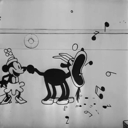

In [14]:
display_tensor_as_gif(clips[0])

In [ ]:
show_grayscale_image(clips[0][:, 2, :, :])

In [ ]:
print(imageio.plugins.ffmpeg.download())

In [ ]:
!pip install torch imageio ipython
!pip install imageio-ffmpeg

In [ ]:
!pip install --no-cache-dir imageio-ffmpeg